# Mercari Price Suggestion Challenge
[A Santosh Kumar](https://github.com/santoshk17) - Feb 2018

### Contents
1. [Introduction](#intro)
    * [Packages Needed](#package)
2. [Exploratory Data Analysis and Feature Engineering](#eda)
    * [Loading data](#loading_data)
    * [Price Distribution](#price_distribution)
    * [Word Count](#word_count)
    * [Handling Missing Data](#Handling_Missing_Data)
    * [Categorial Data](#categorical_data)
    * [Adding SubCategories](#Adding_SubCategories)
    * [Retrieving Brand Name](#Retrieving_Brand_Name)
    * [Text to Sequence](#Text_to_Sequence)
    * [RMSLE](#rmsle)
 
3. [RNN Model](#rnn_model)
    * [Model Building](#Model_Building)
    * [Model Evaluation](#Model_Evaluation)
    * [Model Output](#Model_Output)
    
4. [Ridge Models](#ridge_models)
     * [Data Preprocessing](#Data_Preprocessing)
     * [Model Building](#Model_Building1)
     * [Model Evaluation](#Model_Evaluation1)
5. [Ensembling](#ensembling)
6. [Conclusion](#Conclusion)
7. [Refrences](#Refrences)
   



<a id="intro"></a>
## <center>1. Introduction</center>

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

<a id="package"></a>
#### Packages Needed

In [1]:
import gc
import os
import re
import sys
import time
import wordbatch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt



# for text data
from keras.preprocessing.text import Tokenizer
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL, FM_FTRL
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, hstack

#  for splitting data in to train and validation sets
from sklearn.model_selection import train_test_split

# RNN Model related
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

sys.path.insert(0, '../input/wordbatch/wordbatch/')


In [3]:
trainDF = pd.read_table('../input/mercari-price-suggestion-challenge/train.tsv', engine='c')
testDF = pd.read_table('../input/mercari-price-suggestion-challenge/test.tsv', engine='c')

In [4]:
print('Train shape: ', trainDF.shape)
print('Test shape: ', testDF.shape)

Train shape:  (1482535, 8)
Test shape:  (693359, 7)


In [5]:
trainDF.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


<a id="price_distribution"></a>
#### Price Distribution

In [6]:
trainDF.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

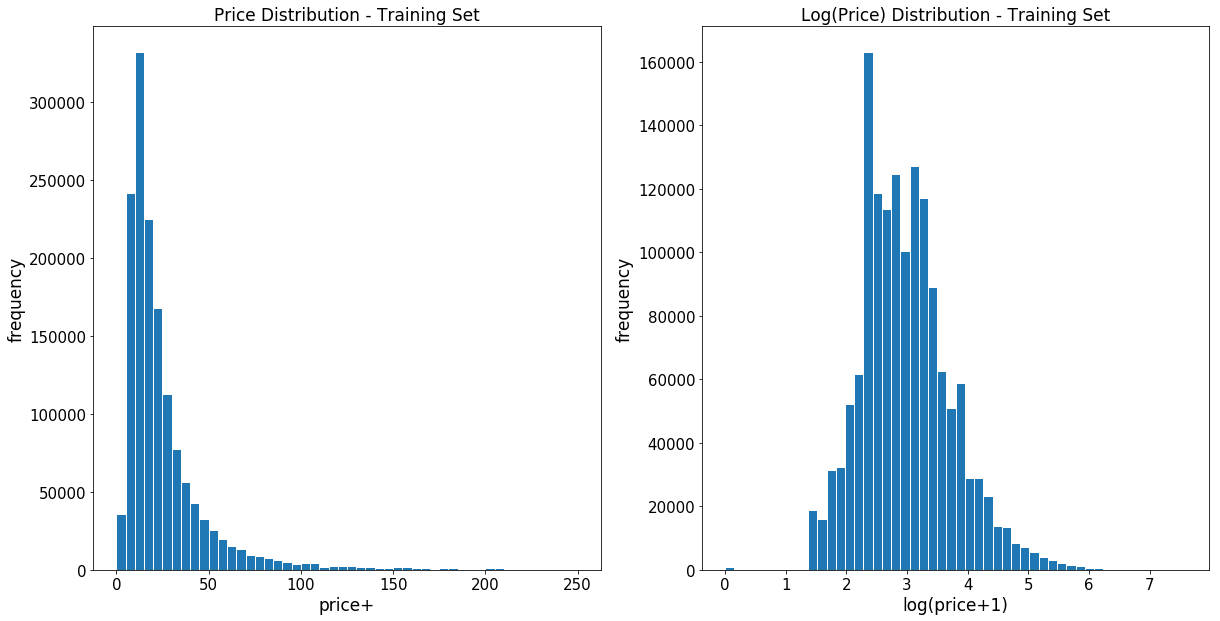

In [7]:
plt.subplot(1, 2, 1)
(trainDF['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)


plt.subplot(1, 2, 2)
np.log(trainDF['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()  

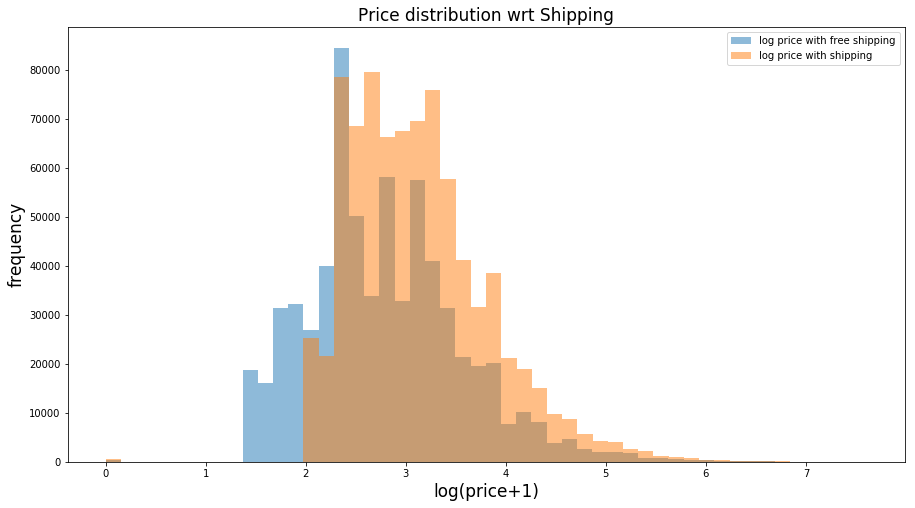

In [8]:
plt.figure(figsize = (15, 8))
plt.hist(np.log(trainDF[trainDF.shipping == 1].price+1), bins = 50, alpha = 0.5, label = "log price with free shipping")
plt.hist(np.log(trainDF[trainDF.shipping == 0].price+1), bins = 50, alpha = 0.5, label = "log price with shipping")
plt.legend(fontsize = 10)
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price distribution wrt Shipping', fontsize=17)
plt.show()

The minimum price of a product is zero, few products have price close to 0. These seem to be outliers. 
For the purpose of analysis these will be dropped.

In [9]:
# Dropping low price 
trainDF = trainDF.drop(trainDF[(trainDF.price < 1.0)].index)
trainDF.shape

(1481661, 8)

<a id="word_count"></a>
#### Word Count

wordCount finds the number of words in given text.  

In [10]:
# get name and description lengths
def WordCount(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0
trainDF['desc_len'] = trainDF['item_description'].apply(lambda x: WordCount(x))
testDF['desc_len'] = testDF['item_description'].apply(lambda x: WordCount(x))
trainDF['name_len'] = trainDF['name'].apply(lambda x: WordCount(x))
testDF['name_len'] = testDF['name'].apply(lambda x: WordCount(x))
trainDF.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,name_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,0,7
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,29,2
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,5,4


<a id="Adding_SubCategories"></a>
#### Adding SubCategories

Mostly there are three subcategories in category name. 
**SplitCategory** function generates three new columns by splitting category_name in to three sub categories.

In [11]:
# split category name into 3 parts
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
trainDF['subcat_0'], trainDF['subcat_1'], trainDF['subcat_2'] = \
zip(*trainDF['category_name'].apply(lambda x: split_cat(x)))
testDF['subcat_0'], testDF['subcat_1'], testDF['subcat_2'] = \
zip(*testDF['category_name'].apply(lambda x: split_cat(x)))

In [12]:
trainDF.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,name_len,subcat_0,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,0,7,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,29,2,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,5,4,Women,Jewelry,Necklaces


<a id="Retrieving_Brand_Name"></a>
#### Retreiving Brand Name

Retriving missing brand names

In [13]:
full_set = pd.concat([trainDF,testDF])
brands = set(full_set['brand_name'].values)
trainDF.brand_name.fillna(value="missing", inplace=True)
testDF.brand_name.fillna(value="missing", inplace=True)

In [14]:
print("Missing brand names")
print ("Number of items with missing brand names in training set : {missingTrain} ".format(missingTrain=len(trainDF.loc[trainDF['brand_name'] == 'missing'])))
print ("Number of items with missing brand names in test set : {missingTest} ".format(missingTest=len(testDF.loc[testDF['brand_name'] == 'missing'])))

Missing brand names
Number of items with missing brand names in training set : 632336 
Number of items with missing brand names in test set : 295525 


In [15]:
uniqueBrands = trainDF["brand_name"].value_counts()
print("There are", uniqueBrands.size, "unique known brands.")

There are 4808 unique known brands.


For some items brand names could be made out from their name.
 *BrandFinder* is the function which will do this.  

In [16]:
# get to finding!
missingBrandNamesTrain = len(trainDF.loc[trainDF['brand_name'] == 'missing'])
missingBrandNamesTest = len(testDF.loc[testDF['brand_name'] == 'missing'])
def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    if brand == 'missing':
        for x in namesplit:
            if x in brands:
                return name
    if name in brands:
        return name
    return brand

In [17]:
trainDF['brand_name'] = trainDF[['brand_name','name']].apply(brandfinder, axis = 1)
testDF['brand_name'] = testDF[['brand_name','name']].apply(brandfinder, axis = 1)
foundBrandNamesTrain = missingBrandNamesTrain-len(trainDF.loc[trainDF['brand_name'] == 'missing'])
foundBrandNamesTest = missingBrandNamesTest-len(testDF.loc[testDF['brand_name'] == 'missing'])

In [18]:
print ("Found brand names for {foundTrain} items in training set ".format(foundTrain = foundBrandNamesTrain))
print ("Found brand names for {foundTest} items in test set ".format(foundTest = foundBrandNamesTest))

Found brand names for 137342 items in training set 
Found brand names for 64154 items in test set 


In [19]:
# Scale target variable to log.
trainDF["target"] = np.log1p(trainDF.price)

# Split training examples into train/dev examples.
trainDF, validationDF = train_test_split(trainDF, random_state=123, train_size=0.99)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
# Calculate number of train/dev/test examples.
print("Training on",trainDF.shape[0], "samples")
print("Validating on", validationDF.shape[0], "samples")
print("Testing on", testDF.shape[0], "samples")

Training on 1466844 samples
Validating on 14817 samples
Testing on 693359 samples


In [21]:
fullDF = pd.concat([trainDF, validationDF, testDF])


<a id="Handling_Missing_Data"></a>
#### Handling Missing Data

In [22]:
def FillMissingValues(df):
    df.category_name.fillna(value="missing", inplace=True)
    df.brand_name.fillna(value="missing", inplace=True)
    df.item_description.fillna(value="missing", inplace=True)
    df.item_description.replace('No description yet',"missing", inplace=True)
    return df

print("Filling missing data...")
full_df = FillMissingValues(fullDF)


Filling missing data...


<a id="categorical_data"></a>
#### Categorical Data

In [23]:
print("Processing categorical data...")
le = LabelEncoder()
# full_df.category = full_df.category_name
le.fit(fullDF.category_name)
fullDF['category'] = le.transform(fullDF.category_name)

le.fit(fullDF.brand_name)
fullDF.brand_name = le.transform(fullDF.brand_name)

le.fit(fullDF.subcat_0)
fullDF.subcat_0 = le.transform(fullDF.subcat_0)

le.fit(fullDF.subcat_1)
fullDF.subcat_1 = le.transform(fullDF.subcat_1)

le.fit(fullDF.subcat_2)
fullDF.subcat_2 = le.transform(fullDF.subcat_2)

del le

Processing categorical data...


<a id="Text_to_Sequence"></a>
#### Text to Sequence

In [24]:
print("Transforming text data to sequences...")
raw_text = np.hstack([fullDF.item_description.str.lower(), fullDF.name.str.lower(), fullDF.category_name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

print("   Transforming text to sequences...")
fullDF['seq_item_description'] = tok_raw.texts_to_sequences(fullDF.item_description.str.lower())
fullDF['seq_name'] = tok_raw.texts_to_sequences(fullDF.name.str.lower())
# full_df['seq_category'] = tok_raw.texts_to_sequences(full_df.category_name.str.lower())

del tok_raw

Transforming text data to sequences...
   Fitting tokenizer...
   Transforming text to sequences...


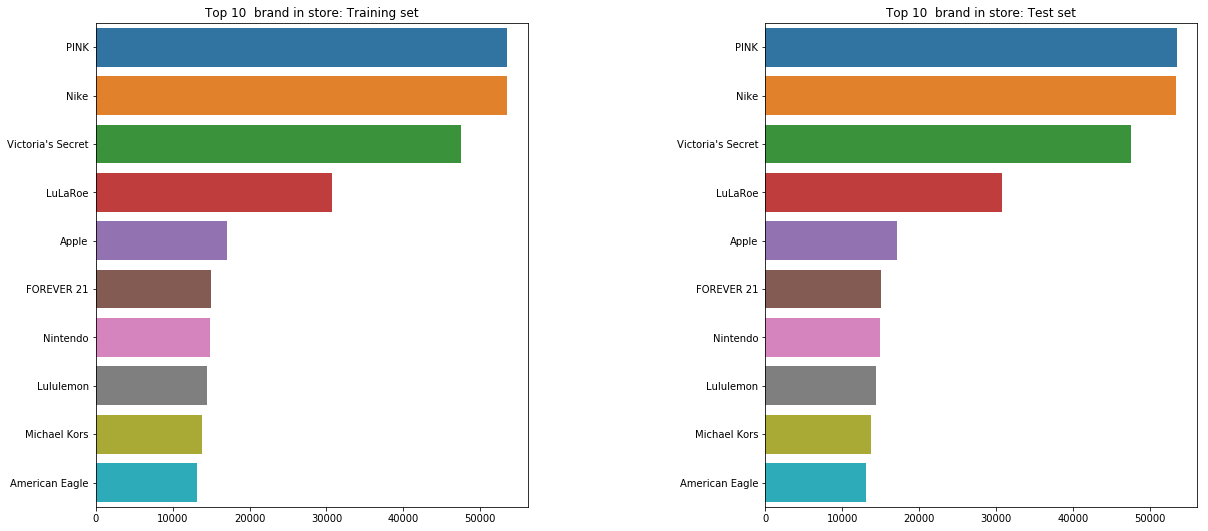

In [25]:

brands = trainDF["brand_name"].value_counts()
plt.figure(1,figsize = (18,8))
plt.subplot(121)
sns.barplot(brands[1:11].values, brands[1:11].index)
plt.title("Top 10  brand in store: Training set")
#plt.show()

plt.subplot(122)
sns.barplot(brands[1:11].values, brands[1:11].index)
plt.title("Top 10  brand in store: Test set")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=6.55, wspace=0.55)
plt.show()



It can be seen that data distribution is same for test and train sets

<a id="rmsle"></a>
#### RMSLE


Root Mean Squared Logarithmic Error (RMSLE)
$$\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(Y_{p}) - \log(Y_{t}))^2 }$$
$ Y_{p}:  predicted    $ 

$ Y_{t}:  true  $

In [ ]:
def RMSLE (predicted, true):
    assert len(predicted) == len(true)
    return np.sqrt(np.mean(np.power(np.log1p(predicted) - np.log1p(true), 2)))

<a id="rnn_model"></a>
## <center>RNN Model</center>

<a id="Model_Building"></a>
#### Model Building

These are some of the constants related to data.

In [ ]:
MAX_NAME_SEQ = 10 
MAX_ITEM_DESC_SEQ = 75 
MAX_CATEGORY_SEQ = 8 
MAX_TEXT = np.max([ np.max(fullDF.seq_name.max()),np.max(fullDF.seq_item_description.max())]) + 100
MAX_CATEGORY = np.max(fullDF.category.max()) + 1
MAX_BRAND = np.max(fullDF.brand_name.max()) + 1
MAX_CONDITION = np.max(fullDF.item_condition_id.max()) + 1
MAX_DESC_LEN = np.max(fullDF.desc_len.max()) + 1
MAX_NAME_LEN = np.max(fullDF.name_len.max()) + 1
MAX_SUBCAT_0 = np.max(fullDF.subcat_0.max()) + 1
MAX_SUBCAT_1 = np.max(fullDF.subcat_1.max()) + 1
MAX_SUBCAT_2 = np.max(fullDF.subcat_2.max()) + 1

In [ ]:
n_trains = trainDF.shape[0]
n_validate = validationDF.shape[0]
n_tests = testDF.shape[0]

In [ ]:
def get_rnn_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category': np.array(dataset.category),
#         'category_name': pad_sequences(dataset.seq_category, maxlen=MAX_CATEGORY_SEQ),
        'item_condition': np.array(dataset.item_condition_id),
        'num_vars': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'subcat_0': np.array(dataset.subcat_0),
        'subcat_1': np.array(dataset.subcat_1),
        'subcat_2': np.array(dataset.subcat_2),
    }
    return X



In [ ]:
train = fullDF[:n_trains]
validate = fullDF[n_trains:n_trains+n_validate]
test = fullDF[n_trains+n_validate:]

X_train = get_rnn_data(train)
Y_train = train.target.values.reshape(-1, 1)

X_validate = get_rnn_data(validate)
Y_validate = validate.target.values.reshape(-1, 1)

X_test = get_rnn_data(test)

In [ ]:
# set seed again in case testing models adjustments by looping next 2 blocks
np.random.seed(123)

def new_rnn_model(lr=0.001, decay=0.0):
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
#     category = Input(shape=[1], name="category")
#     category_name = Input(shape=[X_train["category_name"].shape[1]], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    desc_len = Input(shape=[1], name="desc_len")
    name_len = Input(shape=[1], name="name_len")
    subcat_0 = Input(shape=[1], name="subcat_0")
    subcat_1 = Input(shape=[1], name="subcat_1")
    subcat_2 = Input(shape=[1], name="subcat_2")

    # Embeddings layers (adjust outputs to help model)
    emb_name = Embedding(MAX_TEXT, 20)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
#     emb_category_name = Embedding(MAX_TEXT, 20)(category_name)
#     emb_category = Embedding(MAX_CATEGORY, 10)(category)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_desc_len = Embedding(MAX_DESC_LEN, 5)(desc_len)
    emb_name_len = Embedding(MAX_NAME_LEN, 5)(name_len)
    emb_subcat_0 = Embedding(MAX_SUBCAT_0, 10)(subcat_0)
    emb_subcat_1 = Embedding(MAX_SUBCAT_1, 10)(subcat_1)
    emb_subcat_2 = Embedding(MAX_SUBCAT_2, 10)(subcat_2)
    

    # rnn layers (GRUs are faster than LSTMs and speed is important here)
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
#     rnn_layer3 = GRU(8) (emb_category_name)

    # main layers
    main_l = concatenate([
        Flatten() (emb_brand_name)
#         , Flatten() (emb_category)
        , Flatten() (emb_item_condition)
        , Flatten() (emb_desc_len)
        , Flatten() (emb_name_len)
        , Flatten() (emb_subcat_0)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , rnn_layer1
        , rnn_layer2
#         , rnn_layer3
        , num_vars
    ])
    # (incressing the nodes or adding layers does not effect the time quite as much as the rnn layers)
    main_l = Dropout(0.1)(Dense(512,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))

    # the output layer.
    output = Dense(1, activation="linear") (main_l)
    
    model = Model([name, item_desc, brand_name , item_condition, 
                   num_vars, desc_len, name_len, subcat_0, subcat_1, subcat_2], output)

    optimizer = Adam(lr=lr, decay=decay)
    # (mean squared error loss function works as well as custom functions)  
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = new_rnn_model()
model.summary()
del model

In [ ]:
BATCH_SIZE = 512 * 3
epochs = 2

# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train['name']) / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

# Create model and fit it with training dataset.
rnn_model = new_rnn_model(lr=lr_init, decay=lr_decay)
rnn_model.fit(
        X_train, Y_train, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_validate, Y_validate), verbose=1,
)


<a id="Model_Evaluation"></a>
#### Model Evaluation

In [ ]:
print("Evaluating the model on validation data...")
Y_validate_preds_rnn = rnn_model.predict(X_validate, batch_size=BATCH_SIZE)
print(" RMSLE error:", RMSLE(Y_validate, Y_validate_preds_rnn))

<a id="Model_Output"></a>
#### Model Output

In [ ]:
rnn_preds = rnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
rnn_preds = np.expm1(rnn_preds)

<a id="ridge_model"></a>
## <center>Ridge Model</center>

In [ ]:
fullDF = pd.concat([trainDF, validationDF, testDF])

Converting to string

In [ ]:
print("Handling missing values...")
fullDF['category_name'] = fullDF['category_name'].fillna('missing').astype(str)
fullDF['subcat_0'] = fullDF['subcat_0'].astype(str)
fullDF['subcat_1'] = fullDF['subcat_1'].astype(str)
fullDF['subcat_2'] = fullDF['subcat_2'].astype(str)
fullDF['brand_name'] = fullDF['brand_name'].fillna('missing').astype(str)
fullDF['shipping'] = fullDF['shipping'].astype(str)
fullDF['item_condition_id'] = fullDF['item_condition_id'].astype(str)
fullDF['desc_len'] = fullDF['desc_len'].astype(str)
fullDF['name_len'] = fullDF['name_len'].astype(str)
fullDF['item_description'] = fullDF['item_description'].fillna('No description yet').astype(str)

**Vectorizig Data**

**CountVectorizer** :Converts a collection of text documents to a matrix of token counts

In [ ]:

default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(fullDF.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
#     ('category_name', CountVectorizer(
#         token_pattern='.+',
#         preprocessor=build_preprocessor('category_name'))),
    ('subcat_0', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('subcat_0'))),
    ('subcat_1', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('subcat_1'))),
    ('subcat_2', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('subcat_2'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('desc_len', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('desc_len'))),
    ('name_len', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('name_len'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        preprocessor=build_preprocessor('item_description'))),
])

X = vectorizer.fit_transform(fullDF.values)

X_train = X[:n_trains]
Y_train = trainDF.target.values.reshape(-1, 1)

X_dev = X[n_trains:n_trains+n_devs]
Y_dev = validationDF.target.values.reshape(-1, 1)

X_test = X[n_trains+n_devs:]
print(X.shape, X_train.shape, X_dev.shape, X_test.shape)

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

<a id="Model_Building1"></a>
#### Model Building

In [ ]:
print("Fitting Ridge model on training examples...")
ridge_model = Ridge(
    solver='auto', fit_intercept=True, alpha=1.0,
    max_iter=100, normalize=False, tol=0.05, random_state = 1,
)
ridge_modelCV = RidgeCV(
    fit_intercept=True, alphas=[5.0],
    normalize=False, cv = 2, scoring='neg_mean_squared_error',
)
ridge_model.fit(X_train, Y_train)
ridge_modelCV.fit(X_train, Y_train)

<a id="Model_Evaluation1"></a>
#### Model Evaluation

In [ ]:
Y_dev_preds_ridge = ridge_model.predict(X_dev)
Y_dev_preds_ridge = Y_validation_preds_ridge.reshape(-1, 1)
print("RMSL error on validation set:", rmsle(Y_dev, Y_dev_preds_ridge))

In [ ]:
Y_dev_preds_ridgeCV = ridge_modelCV.predict(X_dev)
Y_dev_preds_ridgeCV = Y_dev_preds_ridgeCV.reshape(-1, 1)
print("CV RMSL error on dev set:", rmsle(Y_dev, Y_dev_preds_ridgeCV))

<a id="Model_Output1"></a>
#### Model Output

In [ ]:
ridge_preds = ridge_model.predict(X_test)
ridge_preds = np.expm1(ridge_preds)
ridgeCV_preds = ridge_modelCV.predict(X_test)
ridgeCV_preds = np.expm1(ridgeCV_preds)

<a id="ensemblingl"></a>
## <center>Ensembling</center>

Here all the three models are considered. This model will give good result for a pair value of ratio1 and ratio2.

In [ ]:
def aggregate_predicts3(Y1, Y2, Y3, ratio1, ratio2):
    assert Y1.shape == Y2.shape
    return Y1 * ratio1 + Y2 * ratio2 + Y3 * (1.0 - ratio1-ratio2)

<a id="Conclusion"></a>
## <center>Conclusion</center>

 Gradient boost models like LGBM and XGBoost could be considered.   Given the resource constraint this couldn't be done.
 A better model could be obtained by tweaking RNN parameters. 


<a id="Refrences"></a>
## <center>Refrences</center>

https://www.kaggle.com/mercari-team